In [51]:
!pip3 install gym

import gym
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict
from functools import partial
%matplotlib inline
plt.style.use('ggplot')


You should consider upgrading via the 'C:\Users\SLY\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [52]:
#Initialize environment
#Observation here encompassess all data about state that we need, as well as reactions to it
env = gym.make('Blackjack-v1')

#Define a policy where we hit until we reach 19.
# actions here are 0-stand, 1-hit


def sample_policy(observation):
    if len(observation) == 2:
        a, b = observation
        score, dealer_score, usable_ace = a
    elif len(observation) == 3:
        score, dealer_score, usable_ace = observation
    return 0 if score >= 19 else 1


#Generate an episode - game from start until some terminal ending -win, loss, draw

def generate_episode(policy, env):

    # we initialize the list for storing states, actions, and rewards
    states, actions, rewards = [], [], []

    # Initialize the gym environment
    observation = env.reset()

    while True:

        # append the states to the states list
        states.append(observation)

        # now, we select an action using our sample_policy function and append the action to actions list

        action = sample_policy(observation)
        actions.append(action)

        # We perform the action in the environment according to our sample_policy, move to the next state
        # and receive reward
        observation, reward, done, info, test = env.step(action)
        rewards.append(reward)

        # Break if the state is a terminal state (i.e. done)
        if done:
            break

    return states, actions, rewards


In [53]:
def first_visit_mc_prediction(policy, env, n_episodes):

    # First, we initialize the empty value table as a dictionary for storing the values of each state
    value_table = defaultdict(float)
    N = defaultdict(int)

    for _ in range(n_episodes):

        # Next, we generate the epsiode and store the states and rewards

        states, _, rewards = generate_episode(policy, env)
        returns = 0

        # Then for each step, we store the rewards to a variable R and states to S, and we calculate
        # returns as a sum of rewards

        #For each episode, we can calculate the current value of all the states invovled. Done in reverse order from terminal state.
        #TODO double check if some tof these are 0, as we discussed

        for t in range(len(states) - 1, -1, -1):
            R = rewards[t]
            S = states[t]

            returns += R

            # Now to perform first visit MC, we check if the episode is visited for the first time, if yes,
            #This is the standard Monte Carlo Incremental equation.
            # NewEstimate = OldEstimate+StepSize(Target-OldEstimate)
            # we simply take the average of returns and assign the value of the state as an average of returns

            if S not in states[:t]:
                if len(S) == 2:
                    x, y = S
                else:
                    x = S
                N[x] += 1
                value_table[x] += (returns - value_table[x]) / N[x]

    return value_table


value = first_visit_mc_prediction(sample_policy, env, n_episodes=500000)


for i in range(10):
  print(value.popitem())


C:\Users\SLY\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


((14, 9, True), -0.12578616352201258)
((4, 4, False), -0.2807017543859649)
((13, 1, True), -0.31927710843373514)
((13, 6, True), -0.03784860557768926)
((13, 4, True), -0.08525345622119819)
((4, 2, False), -0.30909090909090925)
((12, 9, True), -0.034883720930232565)
((12, 7, True), -0.055319148936170216)
((12, 8, True), 0.03636363636363635)
((16, 1, True), -0.46026490066225145)


In [54]:
def plot_blackjack(V, ax1, ax2):
    player_sum = np.arange(12, 21 + 1)
    dealer_sum = np.arange(1, 10 + 1)
    usable_ace = np.array([False, True])
    state_values = np.zeros((len(player_sum), len(dealer_sum), len(usable_ace)))
 
    for i, player in enumerate(player_sum):
        for j, dealer in enumerate(dealer_sum):
            for k, ace in enumerate(usable_ace):
                state_values[i, j, k] = V[player, dealer, ace]
    
    X, Y = np.meshgrid(player_sum, dealer_sum)
 
    ax1.plot_wireframe(X, Y, state_values[:, :, 0])
    ax2.plot_wireframe(X, Y, state_values[:, :, 1])
 
    for ax in ax1, ax2:
        ax.set_zlim(-1, 1)
        ax.set_ylabel('player sum')
        ax.set_xlabel('dealer sum')
        ax.set_zlabel('state-value')

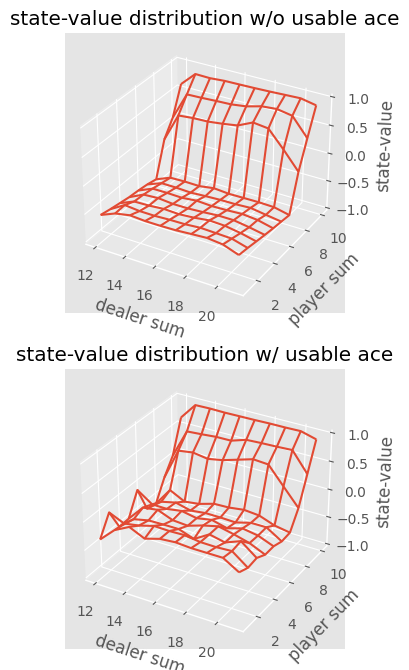

In [55]:
fig, axes = pyplot.subplots(nrows=2, figsize=(5, 8),
subplot_kw={'projection': '3d'})
axes[0].set_title('state-value distribution w/o usable ace')
axes[1].set_title('state-value distribution w/ usable ace')
plot_blackjack(value, axes[0], axes[1])